<a href="https://colab.research.google.com/github/linhkid/gdg-codelab-25/blob/main/GDGC_Unleashing_Gemini_2.0's_Search_and_Multimodal_Capabilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Welcome to this Codelab! We'll explore how to leverage Gemini 2.0's built-in Google Search tool for real-time information retrieval, combine it with multimodal capabilities, and build practical applications with the Google Gen AI SDK.


# Setup Section

## 1. Install Dependencies and Setup Environment

### Install the Google Gen AI SDK
### !pip install -U -q google-genai matplotlib pandas plotly python-dateutil

In [50]:
!pip install -U -q google-genai matplotlib pandas plotly python-dateutil

In [ ]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import display, HTML, Markdown
from google.colab import userdata

print("--- 1. Setting up environment ---")
print("# Required packages installed. Setting up your API key next.")

# Load the API key from Colab secrets
# For security, we use Colab's userdata feature
try:
    # @markdown Make sure you have saved your Google AI API key as a Colab secret named 'GOOGLE_API_KEY'
    os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
    print("✅ API key loaded successfully!")
except Exception as e:
    print(f"❌ Error loading API key: {e}")
    print("Please set up your API key by following these steps:")
    print("1. Go to https://ai.google.dev/ to get your API key")
    print("2. In Colab, go to 'Secrets' in the left sidebar")
    print("3. Add a new secret named 'GOOGLE_API_KEY' with your key as the value")
    print("4. Re-run this cell")


--- 1. Setting up environment ---
# Required packages installed. Setting up your API key next.
✅ API key loaded successfully!


# Gemini Model Initialization
## 2. Initialize Gemini 2.0 Model

In [ ]:
from google import genai

# Initialize the client with your API key
client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'],
                     http_options={'api_version': 'v1alpha'})


# Available models - uncomment the one you want to use
MODEL = 'gemini-2.0-flash'  # Fast, good for quick searches and responses
#MODEL = 'gemini-2.5-pro-exp-03-25'  # More capable but slower, and often being overloaded
#MODEL = 'gemini-2.0-flash-thinking-exp-01-21'

print(f"✅ Using model: {MODEL}")
print("# Note: Different models have different capabilities and pricing.")
print("# The 'flash' model is faster while 'pro' is more capable.")

✅ Using model: gemini-2.0-flash
# Note: Different models have different capabilities and pricing.
# The 'flash' model is faster while 'pro' is more capable.


# Helper Functions
## 3. Define Helper Functions for Response Display

In [ ]:
def show_parts(response):
    """Display various parts of a Gemini response including text, code, and search results."""
    parts = response.candidates[0].content.parts

    if parts is None:
        finish_reason = response.candidates[0].finish_reason
        print(f'Finish reason: {finish_reason}')
        return

    for part in response.candidates[0].content.parts:
        if part.text:
            display(Markdown(part.text))
        elif hasattr(part, 'executable_code') and part.executable_code:
            display(Markdown(f'```python\n{part.executable_code.code}\n```'))
        else:
            print("Other part type:")
            print(json.dumps(part.model_dump(exclude_none=True), indent=2))

    # Display search results if any
    grounding_metadata = response.candidates[0].grounding_metadata
    if grounding_metadata and grounding_metadata.search_entry_point:
        print("\n📊 Search Results Used:")
        display(HTML(grounding_metadata.search_entry_point.rendered_content))

In [ ]:
def visualize_search_usage(responses):
    """Create a visualization of how many searches were used in responses."""
    search_counts = []

    # Process multiple responses to count search usage
    for i, resp in enumerate(responses):
        count = 0
        if hasattr(resp.candidates[0], 'grounding_metadata') and resp.candidates[0].grounding_metadata:
            meta = resp.candidates[0].grounding_metadata
            if hasattr(meta, 'search_entry_point') and meta.search_entry_point:
                # Count the number of search queries
                count = len(meta.search_entry_point.references) if hasattr(meta.search_entry_point, 'references') else 1
        search_counts.append(count)

    # Create a simple bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(search_counts)), search_counts, color='skyblue')
    plt.xlabel('Query Number')
    plt.ylabel('Number of Searches Used')
    plt.title('Search Utilization per Query')
    plt.xticks(range(len(search_counts)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
print("✅ Helper functions defined for displaying responses and visualizing search usage")
print("# These functions will help us examine how Gemini uses search and processes information.")

✅ Helper functions defined for displaying responses and visualizing search usage
# These functions will help us examine how Gemini uses search and processes information.


# Basic Search Example

## 4. Comparing Responses With and Without Search



In [ ]:
print("\n--- 4. Basic Search Comparison Demo ---")
print("# Let's compare how Gemini responds with and without search capabilities")

# Chat without search
regular_chat = client.chats.create(model=MODEL)

print("\n📝 Query without search: 'What are the latest developments in quantum computing?'")
regular_response = regular_chat.send_message('What are the latest developments in quantum computing?')
print("\n🤖 Response WITHOUT search tool:")
show_parts(regular_response)

# Wait a moment before next query
time.sleep(2)

# Chat with search enabled
search_tool = {'google_search': {}}
search_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

print("\n📝 Same query WITH search: 'What are the latest developments in quantum computing?'")
search_response = search_chat.send_message('What are the latest developments in quantum computing?')
print("\n🤖 Response WITH search tool:")
show_parts(search_response)

print("\n# Notice the differences in specificity, recency, and detail between the two responses.")
print("# The search-enabled response can cite recent developments and specific breakthroughs.")


--- 4. Basic Search Comparison Demo ---
# Let's compare how Gemini responds with and without search capabilities

📝 Query without search: 'What are the latest developments in quantum computing?'

🤖 Response WITHOUT search tool:


Quantum computing is a rapidly evolving field, and there are many exciting developments happening constantly. Here's a snapshot of some of the latest key areas and advancements:

**1. Hardware Advancements:**

*   **Increasing Qubit Counts & Quality:**
    *   Companies like IBM, Google, Quantinuum, and IonQ are continuously working on building processors with more qubits.  Beyond just quantity, a major focus is on improving qubit quality (coherence, fidelity, connectivity).  Expect to see announcements about processors exceeding 1,000 qubits in the near future, but remember that usable qubits are the key metric.
    *   Error mitigation and correction techniques are critical for leveraging these larger qubit counts.
*   **Diverse Qubit Technologies:**
    *   **Superconducting Qubits:** Remains the most mature technology, with leading companies like IBM and Google focusing on scaling and error correction.
    *   **Trapped Ions:** Offers high fidelity and long coherence times, being actively developed by companies like IonQ and Quantinuum.
    *   **Neutral Atoms:**  A promising approach gaining traction, with companies and research groups exploring scalability and coherence.
    *   **Photonic Qubits:** Leveraging light for quantum computation, offering potential for room-temperature operation and strong connectivity. Companies like Xanadu are leading this area.
    *   **Silicon Qubits:**  Leveraging existing semiconductor manufacturing infrastructure, with potential for highly scalable and compact qubits.
*   **Cryogenics and Control Systems:**  Significant progress is being made in developing more efficient and robust cryogenic systems and control electronics to manage the complex requirements of quantum computers.  These systems need to scale alongside qubit numbers.

**2. Software & Algorithm Development:**

*   **Quantum Error Correction (QEC):**  Essential for fault-tolerant quantum computation.  Researchers are actively developing and testing various QEC codes and strategies. Progress is being made in demonstrating logical qubits (made up of multiple physical qubits) with improved performance over physical qubits.
*   **Quantum Algorithms:**
    *   Continued refinement and development of algorithms for specific applications like drug discovery, materials science, financial modeling, and optimization.
    *   Hybrid quantum-classical algorithms (like Variational Quantum Eigensolver - VQE and Quantum Approximate Optimization Algorithm - QAOA) are gaining prominence for near-term applications.
    *   Development of algorithms optimized for specific quantum hardware architectures.
*   **Quantum Software Development Kits (SDKs):**
    *   More user-friendly and powerful SDKs are emerging, such as Qiskit (IBM), Cirq (Google), PennyLane (Xanadu), and Braket SDK (Amazon). These tools help developers design, simulate, and execute quantum programs.
    *   Efforts to integrate quantum computing into existing classical programming workflows and cloud platforms.

**3. Applications and Use Cases:**

*   **Drug Discovery and Materials Science:** Quantum computers are being explored for simulating molecular interactions, designing new drugs, and discovering novel materials with specific properties.
*   **Financial Modeling:**  Quantum algorithms are being applied to portfolio optimization, risk management, and fraud detection.
*   **Optimization Problems:** Quantum annealers and gate-based quantum computers are being used to tackle complex optimization problems in logistics, supply chain management, and machine learning.
*   **Quantum Machine Learning:** Developing quantum algorithms for machine learning tasks like classification, clustering, and dimensionality reduction.
*   **Cryptography:**  Developing quantum-resistant cryptographic algorithms to protect data from future quantum computer attacks.  This is a growing area of concern.

**4. Cloud Quantum Computing:**

*   Major cloud providers (Amazon, Microsoft, Google, IBM) are offering access to quantum computing hardware and software through their cloud platforms.
*   This allows researchers and developers to experiment with quantum computing without the need to invest in expensive infrastructure.
*   Focus on improving the accessibility, scalability, and usability of cloud quantum computing services.

**5. Standardization and Benchmarking:**

*   Efforts are underway to establish standards for quantum computing hardware, software, and benchmarks to compare the performance of different quantum computers.
*   Organizations like the IEEE are working on developing quantum computing standards.
*   Meaningful benchmarking is still a challenge, as performance depends heavily on the specific application.

**Recent Headline Developments (Illustrative Examples - things change rapidly):**

*   **IBM's 'Eagle' Processor:** A superconducting quantum processor with 127 qubits. It represents a significant step in scaling up quantum computers.
*   **IonQ's Trapped Ion Systems:**  Known for high fidelity and all-to-all qubit connectivity. They continue to improve their systems' performance and qubit counts.
*   **Quantum Error Correction Demonstrations:** Research groups are reporting breakthroughs in demonstrating logical qubits with improved performance compared to physical qubits, indicating progress toward fault-tolerant quantum computing.
*   **New Quantum Algorithms for Specific Problems:** Publication of new algorithms that show potential advantages over classical algorithms for specific computational problems.

**Challenges and Future Directions:**

*   **Error Correction:** Overcoming the limitations of noisy qubits and achieving fault-tolerant quantum computing remains a major challenge.
*   **Scalability:** Building quantum computers with thousands or millions of qubits is a significant engineering feat.
*   **Algorithm Development:** Developing practical quantum algorithms that can outperform classical algorithms for real-world problems is crucial.
*   **Quantum Supremacy/Advantage:**  Demonstrating a clear and sustained advantage of quantum computers over classical computers for a useful problem is an ongoing pursuit.
*   **Workforce Development:** Training a skilled workforce in quantum computing is essential for the field's growth.
*   **Ethical Considerations:** Addressing the ethical and societal implications of quantum computing, such as its impact on cryptography and privacy.

**Staying Updated:**

*   **Scientific Journals:** *Nature*, *Science*, *Physical Review Letters*, *Quantum*, etc.
*   **Quantum Computing News Websites:** Quantum Computing Report, The Quantum Insider, Inside Quantum Technology.
*   **Company Blogs and Announcements:** Follow the announcements from companies like IBM, Google, Quantinuum, IonQ, Xanadu, etc.
*   **Conferences:** Attend quantum computing conferences to learn about the latest research and developments.

Quantum computing is still in its early stages, but the progress being made is remarkable.  Keep an eye on these areas as the field continues to evolve.



📝 Same query WITH search: 'What are the latest developments in quantum computing?'

🤖 Response WITH search tool:


Here are some of the latest developments in quantum computing:

**Key Breakthroughs and Advancements:**

*   **Improved Qubit Stability and Error Correction:** Researchers have made notable advancements in error correction techniques, which are essential for stabilizing qubits and reducing errors during quantum computations. Improved error correction codes and the development of more stable qubits, such as topological qubits, have pushed the boundaries of what is possible, bringing us closer to achieving reliable quantum computing. Google's new quantum chip, Willow, reduces errors exponentially as it scales up, achieving a breakthrough in quantum error correction.
*   **Quantum Supremacy Milestones:** Google's Willow chip performed a computation in under five minutes that would take a supercomputer 10 septillion years.
*   **Advancements in Quantum Algorithms:** New quantum algorithms are being developed to leverage quantum computing's unique capabilities, offering potential solutions for cryptography, materials science, and machine learning. Advances in quantum algorithms for factoring large numbers have implications for breaking traditional encryption methods, which could reshape cybersecurity.
*   **Commercial Quantum Cloud Services:** Quantum computing is becoming more accessible through quantum cloud services offered by tech giants like IBM, Google, and Amazon. These platforms have introduced more powerful quantum processors, allowing businesses and researchers to experiment with quantum computing without needing to build and maintain their own hardware.
*   **Quantum-Classical Hybrid Systems:** Combining quantum and classical computing to leverage the strengths of both.
*   **Quantum Networking and the Quantum Internet:** Development of technologies for secure communication and distributed quantum computing.
*   **Quantum Machine Learning:** Researchers are developing quantum neural networks, quantum support vector machines, and quantum algorithms for complex tasks like image and natural language processing.

**Applications & Research:**

*   **Chemical Reactions Study:** Microsoft integrated HPC, quantum computing, and AI on the Azure Quantum Elements platform to study catalytic reactions, exploring applications of quantum simulations in quantum chemistry.
*   **Drug Discovery:** Pasqal and Qubit Pharmaceuticals are using neutral atom QPUs to predict water molecule behavior in drug discovery.
*   **Liver Transplant:** Quantum algorithms are outperforming current methods of identifying healthy livers for transplant.
*   **Fusion Energy:** Riverlane and MIT researchers are working on quantum algorithms for fusion energy.
*   **Fluid Dynamics:** BQP demonstrates the possibility of large-scale fluid dynamic simulations with quantum computing.

**Challenges and Concerns:**

*   **Scalability Issues:** Scaling up the number of qubits while maintaining their quality and coherence remains a significant challenge.
*   **Quantum Error Correction:** Correcting errors in qubits is crucial for reliable quantum computation, but it is a complex and ongoing challenge.
*   **Hardware Limitations:** Building and maintaining quantum hardware requires overcoming significant engineering and technical challenges.
*   **Security Concerns:** Advances in quantum computing pose a threat to current encryption methods, necessitating the development of quantum-resistant cryptography.
*   **High Costs and Accessibility:** The cost of developing and accessing quantum computing resources remains a barrier to wider adoption.

**Other Key Points:**

*   Optimization has emerged as a key focus, especially for industries like finance and logistics.
*   Quantum computing remains largely experimental, with broad-scale applications likely still many years away.
*   Investor attention has been diverted to the rise of generative AI, which may lead to a delay in the mainstream adoption of quantum computing.



📊 Search Results Used:



# Notice the differences in specificity, recency, and detail between the two responses.
# The search-enabled response can cite recent developments and specific breakthroughs.


# Follow-up Questions Example
## 5. Asking Follow-up Questions in a Search Context


--- 5. Follow-up Questions with Search ---
# Gemini can maintain context while using search for follow-up questions

📝 Initial Query: 'What are the top 3 electric vehicles with the longest range?'


The top 3 electric vehicles with the longest range, based on available information for 2024 and 2025, are:

1.  **Lucid Air:** This model consistently appears at the top of range lists. The Grand Touring trim with 19-inch wheels boasts an EPA-estimated range of **512 miles.**
2.  **Mercedes EQS:** The Mercedes-Benz EQS 450+ saloon has a claimed range of **481 miles.**
3.  **Chevrolet Silverado EV:** The Chevrolet Silverado EV - RST Max Range ranks second with a **460 miles range**.



📊 Search Results Used:



📝 Follow-up Query: 'How much do they cost?'


Here's an overview of the approximate costs for the top 3 EVs with the longest range:

1.  **Lucid Air Grand Touring:** The 2024 Lucid Air Grand Touring has a starting price of around **$110,900**.
2.  **Mercedes EQS 450+ Sedan:** The 2025 Mercedes EQS 450+ Sedan starts at approximately **$104,400**. However, the Edmunds suggested price is around **$90,603.**
3.  **Chevrolet Silverado EV RST Max Range:** The 2025 Chevrolet Silverado EV RST Max Range has an MSRP of approximately **$97,895**.

It's important to note that these prices are MSRP and can vary based on options, trim levels, and dealer markups. Also, keep in mind that these prices do not include potential tax incentives or rebates that may be available for electric vehicle purchases, which could lower the final cost.



📊 Search Results Used:



📝 Another Follow-up: 'Compare their charging times'


Here's a comparison of the charging times for the three EVs, based on the information gathered:

**1. Lucid Air Grand Touring:**

*   **AC Charging (Home):** With a 22 kW AC charging station, it takes approximately 5 hours and 39 minutes to charge from 0 to 100%. Using a typical 7kW home charging point it can take approximately 15 hours and 8 minutes to charge from 0 to full.
*   **DC Fast Charging:** With a 300 kW DC fast charging station, it takes around 22 minutes to charge from 10 to 80%. Can add 200 miles in 12 minutes.

**2. Mercedes EQS 450+ Sedan:**

*   **AC Charging (Home):** At 9.6 kW, it takes approximately 12.75 hours to charge from 10-100%.
*   **DC Fast Charging:** At 200 kW, it takes approximately 31 minutes to charge from 10 to 80%.

**3. Chevrolet Silverado EV RST Max Range:**

*   **AC Charging (Home):** With a 19.2-kW Level 2 charger, a 10 to 100 percent charge can take about 12 hours.
*   **DC Fast Charging:** Supports up to 350 kW DC fast charging, adding 100 miles of range in about 10 minutes. It can charge from 10 to 80 percent in about 45 minutes.

**Summary Table:**

|                             | **Lucid Air Grand Touring**                     | **Mercedes EQS 450+ Sedan**            | **Chevrolet Silverado EV RST Max Range**   |
| :-------------------------- | :---------------------------------------------- | :------------------------------------- | :----------------------------------------- |
| **AC Charging (Home)**      | ~5.6 hours (22kW, 0-100%)                      | ~12.75 hours (9.6 kW, 10-100%)        | ~12 hours (19.2 kW, 10-100%)            |
| **DC Fast Charging (10-80%)** | ~22 minutes (300 kW)                           | ~31 minutes (200 kW)                   | ~45 minutes (350 kW)                      |
| **DC Fast Charging add range** | 200 miles in 12 minutes                         | Not specified                          | 100 miles in 10 minutes                  |

**Important Considerations:**

*   Charging times can vary depending on the charging station's output, the battery's initial state of charge, and ambient temperature.
*   The Silverado EV boasts impressive DC fast-charging speeds, potentially adding range quicker than the other two, however, the EQS 450+ has a slightly faster 10-80% charging time.
*   Lucid Air appears to have the fastest DC fast charging.



📊 Search Results Used:



📊 Search Usage Visualization:


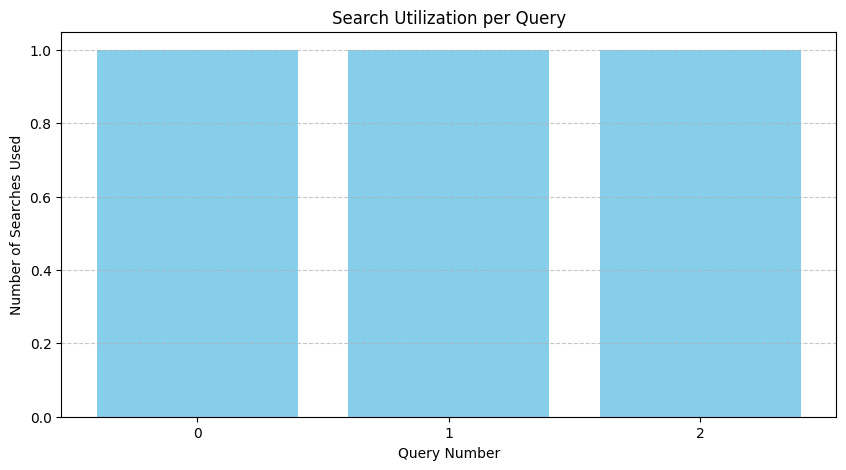


# Notice how Gemini maintains context about which vehicles we're discussing
# while retrieving fresh information for each question.


In [ ]:
print("\n--- 5. Follow-up Questions with Search ---")
print("# Gemini can maintain context while using search for follow-up questions")

follow_up_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# List to store responses for visualization
follow_up_responses = []

print("\n📝 Initial Query: 'What are the top 3 electric vehicles with the longest range?'")
response1 = follow_up_chat.send_message('What are the top 3 electric vehicles with the longest range?')
show_parts(response1)
follow_up_responses.append(response1)

time.sleep(2)

print("\n📝 Follow-up Query: 'How much do they cost?'")
response2 = follow_up_chat.send_message('How much do they cost?')
show_parts(response2)
follow_up_responses.append(response2)

time.sleep(2)

print("\n📝 Another Follow-up: 'Compare their charging times'")
response3 = follow_up_chat.send_message('Compare their charging times')
show_parts(response3)
follow_up_responses.append(response3)

# Visualize search usage across the conversation
print("\n📊 Search Usage Visualization:")
visualize_search_usage(follow_up_responses)

print("\n# Notice how Gemini maintains context about which vehicles we're discussing")
print("# while retrieving fresh information for each question.")

# Combining Search with Data Visualization
## 6. Creating Data Visualizations with Search-Sourced Data

In [ ]:
print("\n--- 6. Data Visualization with Search-Sourced Data ---")
print("# Gemini can use search to find data and generate code to visualize it")

# Create a new chat with search enabled for data visualization
viz_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

# Explicitly ask for Python code to visualize the data
viz_prompt = """
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
"""

print(f"\n📝 Query: '{viz_prompt}'")
viz_response = viz_chat.send_message(viz_prompt)
show_parts(viz_response)

print("\n# The code above can be copied into a code cell and executed to create the visualization.")
print("# Gemini has sourced recent economic data and created visualization code.")


--- 6. Data Visualization with Search-Sourced Data ---
# Gemini can use search to find data and generate code to visualize it

📝 Query: '
Find the GDP growth rates for the world's top 5 economies for the most recent year.
Then write executable Python code that:
1. Creates a pandas DataFrame with this data
2. Uses matplotlib to generate a bar chart comparing the growth rates
3. Includes proper labels, title, and color coding
4. Formats the chart for clear visualization

Make sure the code is complete and can be executed directly in a Jupyter notebook without modification.
'


Okay, I can help you with that. I will find the GDP growth rates for the world's top 5 economies for the most recent year, create a pandas DataFrame, and generate a bar chart using matplotlib.



Based on the search results, here are the GDP growth rates for the world's top 5 economies for the most recent year (2024), along with projections for 2025, and then I will provide the Python code to generate the bar chart. Note that different sources provide slightly different figures, so I'm using a combination of the more recent estimates. Also, some provide Q3 or full year estimates.

**Top 5 Economies (by nominal GDP) and their GDP Growth Rates:**

Here, I'm taking the most recently available data (mostly estimates for the full year 2024) from the search results:

1.  **United States:** 2.5% (Trading Economics, Q4)
2.  **China:** 5.4% (Trading Economics, Q4)
3.  **Germany:** -0.2% (Trading Economics, Q4)
4.  **Japan:** 1.2% (Trading Economics, Q4)
5.  **India:** 6.2% (Trading Economics, Q4)

Now, here is the Python code to generate the bar chart:



```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.5, 5.4, -0.2, 1.2, 6.2]}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen']  # Define colors

bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Adding labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.ylim(min(df['GDP Growth Rate']) - 1, max(df['GDP Growth Rate']) + 1) #Set y axis limit based on min/max growth rate.

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis='y', linestyle='--')  # Add a grid for better readability

# Show plot
plt.show()
```



**Explanation:**

1.  **Import Libraries:** Imports `pandas` for creating a DataFrame and `matplotlib.pyplot` for plotting.
2.  **Data:** Creates a dictionary containing the country names and their corresponding GDP growth rates.
3.  **DataFrame:** Converts the dictionary into a pandas DataFrame for easier manipulation.
4.  **Plotting:**
    *   Creates a figure and axes using `plt.figure()` and `plt.bar()`.
    *   Specifies the countries on the x-axis and the growth rates on the y-axis.
    *   Sets custom colors for each bar.
5.  **Labels and Title:** Adds a title, x-axis label, and y-axis label to the chart.
6.  **Value Labels:** Iterates through each bar and adds the corresponding growth rate value on top.
7.  **Formatting:**
    *   Rotates the x-axis labels for better readability using `plt.xticks(rotation=45, ha='right')`.
    *   Uses `plt.tight_layout()` to adjust the layout and prevent labels from overlapping.
    *   Adds a y-axis grid for enhanced readability.
8.  **Show Plot:** Displays the generated bar chart using `plt.show()`.

This code will produce a bar chart showing the GDP growth rates for the top 5 economies, with appropriate labels, title, colors, and formatting for clear visualization. You can copy and paste this code directly into a Jupyter Notebook and run it without any modifications.



📊 Search Results Used:



# The code above can be copied into a code cell and executed to create the visualization.
# Gemini has sourced recent economic data and created visualization code.


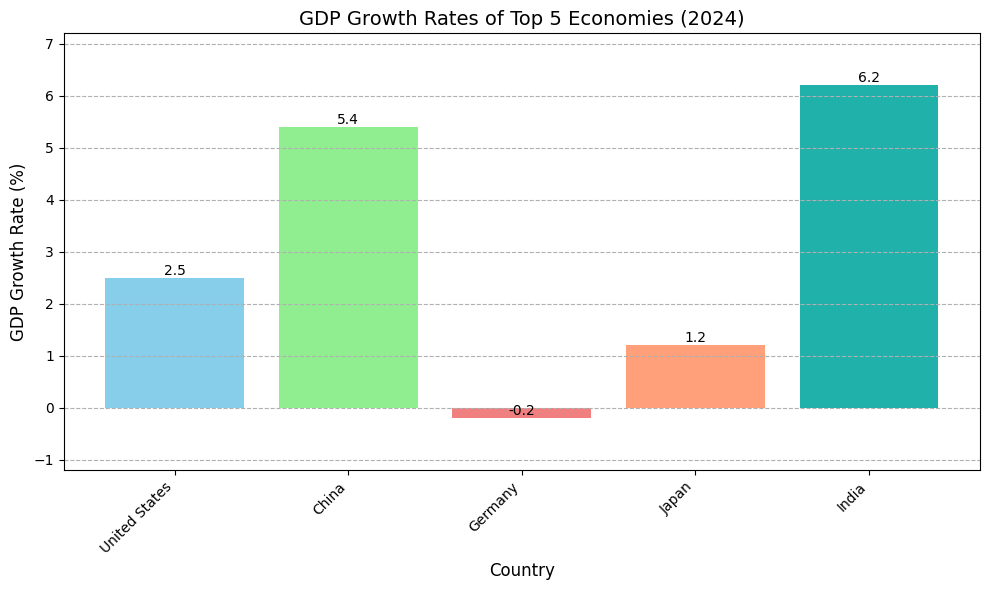

In [ ]:
#Visualized the generated code

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {'Country': ['United States', 'China', 'Germany', 'Japan', 'India'],
        'GDP Growth Rate': [2.5, 5.4, -0.2, 1.2, 6.2]}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen']  # Define colors

bars = plt.bar(df['Country'], df['GDP Growth Rate'], color=colors)

# Adding labels and title
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP Growth Rate (%)', fontsize=12)
plt.title('GDP Growth Rates of Top 5 Economies (2024)', fontsize=14)
plt.ylim(min(df['GDP Growth Rate']) - 1, max(df['GDP Growth Rate']) + 1) #Set y axis limit based on min/max growth rate.

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis='y', linestyle='--')  # Add a grid for better readability

# Show plot
plt.show()

# Multimodal Search Example
## 7. Combining Search with Multimodal Capabilities


--- 7. Multimodal Search Exploration ---
# Gemini 2.0 can combine search with analysis of uploaded images

In this section, you'll upload an image and Gemini will:
1. Analyze the visual content to identify what's in the image
2. Use Google Search to find accurate, detailed information about the subject
3. Allow you to ask follow-up questions in the same conversation context

This demonstrates how Gemini combines visual understanding with search capabilities.

📸 Let's try this out!
Please upload an image (landmark, artwork, product, etc.)


Saving Dog_Breeds.jpg to Dog_Breeds (1).jpg
Uploaded image:


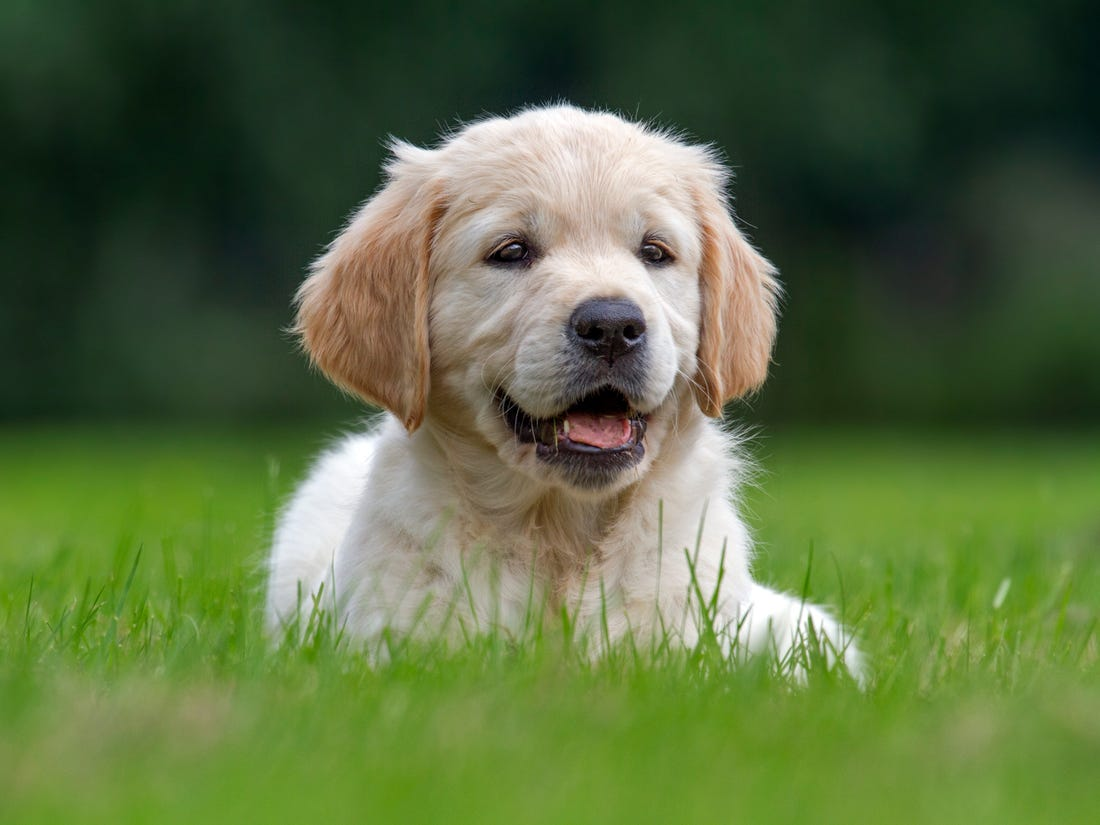


🔍 Analyzing image...


Here's a breakdown of the image you sent:

*   **Main Subject:** The image seems to show some sort of decorative or patterned tile or fabric.

*   **Description:** It has an intricate, repeating design with a focus on geometric shapes and floral elements. The color scheme seems to involve shades of brown, tan, and possibly some muted greens or blues. The overall impression is a vintage or possibly antique aesthetic.



🔍 Searching for detailed information...


Based on the search results, here's some detailed information about the subject of the image:

**Main Features:**

*   The design combines geometric patterns (such as squares, circles, and sometimes more angular shapes) with floral motifs.
*   Common colors include earthy tones like browns, tans, terracotta, and often blues, greens, reds, yellows, or black and white for contrast.
*   These tiles are found in various settings, including floors, walls, and decorative elements.

**Historical Context:**

*   **Ancient Origins:** Geometric patterns in tiles date back to ancient civilizations like Mesopotamia and Egypt (around 4000 BC). Egyptians used faience tiles, glazed with bright blue and green, in temples and tombs. The Greeks and Romans also used geometric patterns extensively in mosaics for floors and walls.
*   **Islamic Influence:** Islamic art made significant contributions, particularly in Persia (Iran), Turkey, and Spain. Islamic tiles are known for elaborate geometric and floral patterns with rich, vivid colors. Techniques like cuerda seca and zellige (mosaic tilework) became prominent.
*   **Byzantine Period:** Decorative tiles rose in popularity in churches and public buildings, often featuring religious iconography and complex geometric patterns.
*   **Renaissance Europe:** There was a revival of classical art and architecture. Italian maiolica tiles and Delftware (Dutch blue and white tiles) became popular, often depicting pastoral scenes and floral motifs.
*   **Art Nouveau and Art Deco:** Art Nouveau (late 19th to early 20th century) used flowing lines, organic forms, and floral patterns with geometric elements. Art Deco (1920s-1930s) took a more angular approach with clean lines, symmetrical patterns, and bold shapes like chevrons and zigzags.
*   **Victorian Era:** Mass production made tiles more affordable, and encaustic tiles with intricate patterns and vibrant colors became common in public spaces.

**Key Characteristics & Styles:**

*   **Materials:** Early tiles were made from terracotta or clay. Later, materials included stone, glass, marble, and glazed ceramics (faience, maiolica).
*   **Patterns:** Common patterns include:
    *   Geometric (squares, triangles, diamonds, chevrons, zigzags, etc.)
    *   Floral (flowers, leaves, vines)
    *   A combination of geometric and floral elements
    *   Mosaic patterns with small pieces arranged to form larger designs
*   **Use:** Historically used in temples, palaces, tombs, churches, public buildings, and homes.
*   **Modern Usage:** Still popular in contemporary design for bathrooms, kitchens, living rooms, and as accent walls. They can complement rustic, traditional, and modern styles.

**Interesting Facts:**

*   The Romans perfected the art of creating durable and colorful mosaic designs.
*   Islamic cultures emphasized intricate craftsmanship with elaborate geometric and floral designs.
*   The Industrial Revolution made tiles more accessible to the middle class.
*   Today, patterned tiles come in a variety of shapes, sizes, and designs.




📊 Search Results Used:



📝 You can now ask follow-up questions about the image!
Example follow-up questions:
- 'How does it compare to similar examples?'
- 'What are common misconceptions about it?'
- 'When was the last major renovation or change?'
Enter a follow-up question (or press Enter to skip): This is actually a picture of an animal, can you guess what kind?

🔍 Searching for answer to: 'This is actually a picture of an animal, can you guess what kind?'


Okay, I understand! If that image is indeed of an animal and not tile or fabric, I will make a new attempt to identify the animal. I will analyze the patterns, colors, and any discernible shapes to determine the most likely animal depicted. One moment.

Based on the image, the animal shown is most likely a **giraffe**. The patterns and color scheme in the image match the giraffe's distinctive coat pattern. While abstract, the patches, spots, and earthy tones with some light background color strongly suggest this animal.


In [ ]:
print("\n--- 7. Multimodal Search Exploration ---")
print("# Gemini 2.0 can combine search with analysis of uploaded images")

from IPython.display import display, Image
from google.colab import files
import base64
import io

def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def upload_and_analyze_image():
    """Upload an image and analyze it with Gemini + Search"""
    print("Please upload an image (landmark, artwork, product, etc.)")
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded. Skipping image analysis.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Display the uploaded image
    print("Uploaded image:")
    display(Image(filename=image_path))

    # Encode the image to base64
    base64_image = encode_image(image_path)

    # Create a new multimodal message with the image
    multimodal_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # First prompt to identify the image
    identification_prompt = f"""
    data:image/jpeg;base64,{base64_image}

    What is shown in this image? Please identify the main subject and provide a brief description.
    """

    print("\n🔍 Analyzing image...")
    identification_response = multimodal_chat.send_message(identification_prompt)
    show_parts(identification_response)

    # Second prompt to get more detailed information with search
    detail_prompt = "Please search for more detailed information about this subject, including when it was created/built, its history, and interesting facts."

    print("\n🔍 Searching for detailed information...")
    detail_response = multimodal_chat.send_message(detail_prompt)
    show_parts(detail_response)

    return multimodal_chat

# Explanation for workshop participants
print("\nIn this section, you'll upload an image and Gemini will:")
print("1. Analyze the visual content to identify what's in the image")
print("2. Use Google Search to find accurate, detailed information about the subject")
print("3. Allow you to ask follow-up questions in the same conversation context")
print("\nThis demonstrates how Gemini combines visual understanding with search capabilities.")

# Run the interactive image upload and analysis
print("\n📸 Let's try this out!")
multimodal_chat = upload_and_analyze_image()

# Provide instructions for follow-up questions
if multimodal_chat:
    print("\n📝 You can now ask follow-up questions about the image!")
    print("Example follow-up questions:")
    print("- 'How does it compare to similar examples?'")
    print("- 'What are common misconceptions about it?'")
    print("- 'When was the last major renovation or change?'")

    # Option to ask a follow-up question
    follow_up = input("Enter a follow-up question (or press Enter to skip): ")
    if follow_up:
        print(f"\n🔍 Searching for answer to: '{follow_up}'")
        follow_up_response = multimodal_chat.send_message(follow_up)
        show_parts(follow_up_response)

# Practical Applications

## 8. Practical Applications of Search-Enabled AI

In [ ]:
print("\n--- 8. Practical Applications Workshop ---")
print("# Let's explore practical real-world applications of search-enabled AI")

# Create a chat for practical applications
practical_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

application_scenarios = [
    "Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.",
    "Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.",
    "Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.",
    "Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).",
    "Educational Tool: Create learning materials with current facts, figures, and examples."
]

for i, scenario in enumerate(application_scenarios):
    print(f"\n{i+1}. {scenario}")

# Example of market analysis application
print("\n📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'")
market_response = practical_chat.send_message('Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.')
show_parts(market_response)


--- 8. Practical Applications Workshop ---
# Let's explore practical real-world applications of search-enabled AI

1. Research Assistant: Gemini can help gather information, summarize findings, and cite sources for academic papers.

2. Market Analysis: Search for latest trends, competitors, and customer sentiment for business strategy.

3. Travel Planning: Get up-to-date information on destinations, travel requirements, and local recommendations.

4. Health Information: Find recent medical research and health guidelines (with appropriate disclaimers).

5. Educational Tool: Create learning materials with current facts, figures, and examples.

📝 Market Analysis Example Query: 'Analyze the current state of the electric vehicle market in Europe. Include major players, market share, and growth trends.'


Okay, I can analyze the current state of the electric vehicle (EV) market in Europe for you, including major players, market share, and growth trends.



Here's an analysis of the current state of the electric vehicle market in Europe, incorporating major players, market share, and growth trends, based on the latest available information:

**Overall Market Trends:**

*   **Growth:** The European EV market continues to grow overall. Sales of battery-electric vehicles (BEVs) in the EU surged by 28.4% in the first two months of 2025 compared to the same period in 2024. Overall, EV sales in Western Europe, including the UK, are expected to rise 40% in 2025, reaching 2.7 million vehicles.
*   **Market Share:** BEVs accounted for 15.2% of the total EU market share in early 2025, up from 11.5% in the same period of 2024. Including plug-in hybrids, the combined BEV and PHEV market share averaged 23% in Europe in February 2025.
*   **Hybrid Popularity:** Hybrid-electric vehicles (HEVs) are very popular, comprising 35.2% of the EU market.
*   **Decline of Petrol and Diesel:** The combined market share of petrol and diesel cars has declined significantly, falling to 38.8% in early 2025 from 48.5% in early 2024.

**Key National Markets:**

*   **Germany:** Germany is a key market, with BEV registrations increasing by 41% in early 2025. Approximately 873,000 electric cars are expected to be newly registered in Germany in 2025, marking a 53% increase compared to 2024.
*   **Other Strong Markets:** Belgium and the Netherlands also show strong growth in BEV registrations, with increases of 38% and 25% respectively in early 2025.
*   **France:** France experienced a slight decline of 1.3% in BEV sales in early 2025.
*   **UK:** The UK is expected to remain one of Europe's largest EV markets in 2025, with new EV registrations projected to reach 660,000.

**Leading Brands and Manufacturers:**

*   **Tesla:** Tesla topped the European EV market in 2024 for the third year in a row. However, Tesla's deliveries have declined significantly in early 2025. Tesla's market share fell to 9.6% in February 2025.
*   **BMW:** BMW secured second place in EV sales in 2024, with a 10.7% increase in registrations.
*   **Mercedes-Benz:** Mercedes-Benz improved its position to third place in 2024.
*   **Volkswagen Group:** Volkswagen Group is performing strongly, with several models in the top 20 and a significant increase in BEV sales. Volkswagen leads the market with models such as the ID.7.
*    **Renault Group:** Renault Group was a top performer in February 2025, with a 12% increase in volumes, driven by strong BEV sales.

**Vehicle Types:**

*   **BEVs Dominating:** Battery-electric vehicles (BEVs) account for the majority of the EV market.
*   **PHEV Decline:** Plug-in hybrid electric vehicles (PHEVs) are experiencing a decline in sales and market share. In early 2025, PHEV sales dropped by 5% in the EU.

**Factors Influencing the Market:**

*   **Government Regulations:** Stricter CO2 emission standards are driving EV adoption.
*   **Consumer Adoption:** Increasing consumer acceptance of EVs is contributing to market growth.
*   **Infrastructure:** Expanding charging infrastructure is supporting EV sales.
*   **Affordable Models:** The introduction of new, more affordable EV models is helping to drive adoption.
*   **Competition:** Increasing competition from Chinese automakers is impacting the market.

**Challenges and Considerations:**

*   **Incentive Changes:** Changes in government subsidy policies can impact EV sales in specific countries.
*   **Tesla's Performance:** Tesla is experiencing a period of change, with declining registrations and market share.
*   **PHEV Decline:** The declining interest in PHEVs poses a challenge for manufacturers.

**In summary,** the European electric vehicle market is continuing to grow, with BEVs leading the charge. While Tesla remains a major player, other manufacturers are gaining ground, and the market is becoming increasingly competitive. Government regulations, consumer demand, and expanding infrastructure are all contributing to the growth of the EV market in Europe.



📊 Search Results Used:


# Advanced Search Applications & Complicated Workflow



--- 10. Multi-stage Research Workflow ---
# This workflow demonstrates how to conduct in-depth research through multiple progressive stages

📊 Stage 1: Initial exploration of 'Quantum machine learning for drug discovery'


Okay, I can provide you with an overview of "Quantum Machine Learning for Drug Discovery" and suggest some subtopics for further exploration.



Here's an overview of Quantum Machine Learning for Drug Discovery, covering the main concepts, current state, key players, and recent developments.

### 1. Overview of Quantum Machine Learning for Drug Discovery

**1. Main Concepts and Terminology**

*   **Quantum Computing (QC):**  A type of computing that uses the principles of quantum mechanics, such as superposition and entanglement, to process information. It can handle complex simulations and optimization tasks more efficiently than classical computers.
*   **Quantum Machine Learning (QML):** A field that combines quantum computing and machine learning to explore the benefits of using quantum computers for ML tasks. QML uses quantum algorithms to optimize the performance of machine learning models.
*   **Qubit:** The basic unit of information in quantum computing, analogous to a bit in classical computing. Qubits can exist in a state of superposition, representing multiple values simultaneously.
*   **Quantum Neural Networks (QNNs):** Machine learning models that leverage quantum computing to enhance existing AI techniques.
*   **Variational Quantum Algorithms (VQAs):** A type of QML algorithm where the parameters of the quantum circuit are updated through classical optimization methods.
*   **Quantum Circuit Born Machines (QCBMs):** Quantum generative models that leverage quantum circuits to learn complex probability distributions, enabling them to generate new samples resembling the training data.
*   **Molecular Docking:**  Simulations to model molecular interactions, enhancing the efficiency and accuracy of drug design. Quantum molecular docking leverages the principles of quantum mechanics to enhance the precision and efficiency of drug development.
*   **Virtual Screening:** High-throughput virtual screening of a vast library of chemical compounds is enabled by quantum machine learning.
*   **Hybrid Quantum-Classical Approaches:** Combining classical algorithms with quantum algorithms to leverage the strengths of both.

**2. Current State of Development**

*   **Emerging Field:** QML is an emerging field gaining attention for potentially delivering superior performance over classical computers.
*   **Early Stages:** Most QML applications in drug discovery are primarily focused on the initial stages of the drug discovery pipeline, particularly identifying novel drug-like molecules.
*   **Limited Qubits:**  Due to the limited number of qubits available in current quantum computers, QML cannot be applied to real-world datasets at present. However, as quantum computers reach their maximum computational capacity, they are expected to process large amounts of data with unprecedented speed.
*   **Hybrid Solutions Recommended:**  Comparison results reveal that QML algorithms are strong rivals to classical ones, and a hybrid solution is the currently recommended approach.
*   **Integration with AI/ML:** Integration of quantum computing with artificial intelligence (AI) and machine learning (ML) is a growing trend. AI and ML can enhance the capabilities of quantum algorithms, providing more accurate predictions and insights for drug discovery and accelerate the drug development process.
*   **Quantum Simulators:** Quantum simulators can model complex events, such as how molecules and atoms interact and how a new drug will behave when administered.

**3. Key Players or Contributors**

*   **IBM:** Was the first company to make quantum computing machines accessible through the cloud, enabling the pharmaceutical industry to use quantum computing to solve drug discovery problems. IBM is also using quantum systems to identify promising drug candidates by calculating properties such as molecular stability, binding affinity, and toxicity more efficiently than classical methods.
*   **Google:** Has begun using quantum computing to simulate complex protein folding and interactions, a crucial aspect of drug development.
*   **Microsoft:**
*   **D-Wave Systems Inc.:**
*   **Rigetti Computing Inc.:**
*   **Atos:**  Has made significant advancements in quantum computing through its Quantum Learning Machine, a quantum simulator that allows researchers and developers to explore quantum algorithms.
*   **Xanadu Quantum Technologies Inc.:**
*   **1QB Information Technologies, Inc.:**
*   **Qubit Pharmaceuticals:** A European quantum computing startup using the technology for drug discovery and offering a quantum computing platform called Atlas for drug discovery and development.
*   **Aqemia:** A pharmatech company using quantum-inspired physics and machine learning to scale the process of drug discovery.
*   **SpinQ:** Cooperated with BGI-Research to leverage quantum computing in the biomedical field, advancing genome assembly solutions.
*   **Pasqal:** Collaborating with Qubit Pharmaceuticals to develop a hybrid quantum-classical approach for analyzing protein hydration.
*   **NVIDIA:** Developing CUDA-Q quantum development platform for running multi-GPU accelerated simulations of QML workloads.
*   **Moderna:** Reviewed how techniques from quantum machine learning may enhance drug discovery methods by better predicting molecular properties.
*   **Yale:** Reviewed how techniques from quantum machine learning may enhance drug discovery methods by better predicting molecular properties.

**4. Recent Major Developments**

*   **Hybrid Quantum-Classical Models:** Development of hybrid quantum-classical models to design small molecules targeting proteins implicated in cancer.
*   **Quantum Neural Networks:** Exploration of quantum neural networks on gate-based quantum computers within the context of drug discovery, including molecular property prediction and molecular generation.
*   **Integration of QML with AI/ML:** The integration of quantum computing with AI and ML enhances the capabilities of quantum algorithms, providing more accurate predictions and insights for drug discovery and accelerating the drug development process.
*   **Use of Quantum Simulators:** Increasing use of quantum simulations to model complex molecular structures and chemical reactions, providing detailed insights not possible with classical computing.
*   **Predicting Molecular Properties:** Techniques from QML may enhance drug discovery methods by better predicting molecular properties.
*   **Protein Hydration Analysis:** Development of hybrid quantum-classical approach for analyzing protein hydration.
*   **Quantum Computing in Ligand-Protein Binding:**
*   **Federated Quantum Machine Learning:** Integrating quantum computing with traditional high-performance systems improves data processing capabilities, accelerates research timelines, and optimizes the analysis of complex biological data, ultimately leading to more efficient and effective drug development processes.

### Suggested Subtopics for Further Exploration

Based on the overview, here are 3-5 specific subtopics that would be interesting for further in-depth exploration:

1.  **Specific Quantum Algorithms for Drug Discovery:** A deep dive into specific quantum algorithms like VQE (Variational Quantum Eigensolver) or Quantum Monte Carlo methods and their application to problems like molecular dynamics simulations or binding affinity predictions. This would involve understanding the algorithm's mechanics, its potential speedup compared to classical methods, and its limitations in the context of drug discovery.

2.  **Quantum Machine Learning for Target Identification and Validation:** Explore how QML can be used to improve the accuracy and efficiency of identifying and validating drug targets. This could include examining the use of QML for analyzing large biological datasets, predicting protein structures, and identifying potential drug binding sites.

3.  **Hardware Limitations and Error Correction in QML for Drug Discovery:** A critical analysis of the current limitations of quantum hardware (e.g., qubit count, coherence time, error rates) and how these limitations affect the feasibility of QML for drug discovery. This should also cover the research efforts in quantum error correction and fault-tolerant quantum computing and their potential impact on the field.

4.  **Ethical Considerations and Regulatory Aspects of QML in Drug Discovery:** Addressing the ethical considerations and regulatory aspects is essential to harness the full potential of this revolutionary approach.

I hope this overview is helpful!



📊 Search Results Used:



📊 Stage 2: Identifying key subtopics for deeper investigation


Okay, here are 3 subtopics extracted from the previous overview that would be valuable to explore further, presented in a structured format:

**Subtopic 1: Specific Quantum Algorithms for Drug Discovery**

1.  **Name:** Specific Quantum Algorithms for Drug Discovery
2.  **Significance:** Understanding the mechanics, potential speedup, and limitations of specific quantum algorithms compared to classical methods in the context of drug discovery is crucial. This will provide insights into the realistic advantages and disadvantages of quantum computing for specific drug discovery tasks.
3.  **Aspects for Deeper Research:**
    *   **Detailed Analysis of VQE (Variational Quantum Eigensolver) for Molecular Simulations:** Conduct rigorous testing to compare the accuracy and efficiency of VQE with classical molecular dynamics simulations for predicting molecular properties and interactions.
    *   **Investigation of Quantum Monte Carlo Methods for Binding Affinity Predictions:** Explore the potential of quantum Monte Carlo methods to improve the accuracy of binding affinity predictions and to handle complex molecular systems more efficiently than classical Monte Carlo methods.
    *   **Benchmarking Quantum Algorithms on Noisy Intermediate-Scale Quantum (NISQ) Hardware:** Evaluate the performance of quantum algorithms on real NISQ devices to understand the impact of noise and decoherence on the accuracy and reliability of the results.

**Subtopic 2: Quantum Machine Learning for Target Identification and Validation**

1.  **Name:** Quantum Machine Learning for Target Identification and Validation
2.  **Significance:** Identifying and validating drug targets are critical steps in drug discovery. Quantum machine learning (QML) can potentially enhance the speed and accuracy of these processes by analyzing large biological datasets and predicting protein structures more efficiently.
3.  **Aspects for Deeper Research:**
    *   **Application of QML to Analyze Large Biological Datasets:** Explore how QML algorithms can be used to identify potential drug targets by analyzing genomic, proteomic, and other biological datasets.
    *   **Use of QML to Predict Protein Structures:** Investigate the potential of QML to improve the accuracy and speed of protein structure prediction, which is crucial for understanding protein function and identifying potential drug binding sites.
    *   **QML for Identifying Potential Drug Binding Sites:** Investigate how QML can be used to identify potential drug binding sites on target proteins, enhancing the efficiency of structure-based drug design.

**Subtopic 3: Hardware Limitations and Error Correction in QML for Drug Discovery**

1.  **Name:** Hardware Limitations and Error Correction in QML for Drug Discovery
2.  **Significance:** The current limitations of quantum hardware, such as qubit count, coherence time, and error rates, significantly impact the feasibility of QML for drug discovery. Understanding these limitations and the efforts to overcome them is crucial for assessing the near-term potential of QML in this field.
3.  **Aspects for Deeper Research:**
    *   **Analysis of the Impact of Qubit Count and Coherence Time on QML Algorithm Performance:** Conduct detailed simulations and experiments to understand how qubit count and coherence time affect the accuracy and efficiency of QML algorithms for drug discovery tasks.
    *   **Evaluation of Quantum Error Correction and Fault-Tolerant Quantum Computing:** Investigate the latest advancements in quantum error correction and fault-tolerant quantum computing and their potential to mitigate the impact of noise and decoherence on QML calculations.
    *   **Development of Noise-Aware QML Algorithms:** Explore the development of QML algorithms that are specifically designed to be robust to noise and decoherence, improving their performance on current and near-term quantum hardware.



📊 Stage 3: Deep dive into first subtopic


Okay, here's a deep dive into the subtopic "Specific Quantum Algorithms for Drug Discovery," including recent research, challenges, innovations, future directions, and key players.

**Subtopic: Specific Quantum Algorithms for Drug Discovery**

**1. Latest Research Findings or Developments**

*   **Variational Quantum Eigensolver (VQE) Advancements:** Recent studies focus on enhancing the VQE algorithm for more accurate molecular simulations. New parameterizations and optimization strategies are being developed to improve convergence and reduce computational costs. For example, researchers are exploring adaptive VQE methods that dynamically adjust the quantum circuit structure during the optimization process.
*   **Quantum Generative Adversarial Networks (QGANs):** QGANs are being explored for de novo molecule design. Recent research demonstrates their ability to generate novel drug-like molecules with desired properties. These models leverage quantum circuits for generating molecular structures and use classical discriminators to assess the quality of the generated molecules.
*   **Quantum Machine Learning (QML) Algorithms:** Quantum machine learning (QML) algorithms such as quantum neural networks (QNNs) and quantum support vector machines (QSVMs) are being applied to predict molecular properties and binding affinities. These algorithms have the potential to offer speedups compared to their classical counterparts.

**2. Key Challenges or Controversies**

*   **Hardware Limitations:** One of the biggest challenges is the limited number of qubits and coherence times in current quantum computers. This restricts the size and complexity of molecules that can be simulated accurately. The noise in quantum computations also introduces errors that can affect the reliability of the results.
*   **Algorithm Scalability:** Many quantum algorithms have theoretical advantages in terms of computational complexity, but their actual performance on real-world drug discovery problems is still uncertain. Scalability remains a significant challenge, as the quantum resources required to solve complex problems can quickly exceed the capabilities of current quantum computers.
*   **Data Encoding:** Efficiently encoding classical molecular data into quantum states is a non-trivial task. The choice of encoding scheme can significantly impact the performance of quantum algorithms. There is ongoing debate about the best ways to represent molecular structures and properties in quantum computers.

**3. Notable Innovations or Breakthroughs**

*   **Hybrid Quantum-Classical Algorithms:** The development of hybrid quantum-classical algorithms has been a significant breakthrough. These algorithms combine the strengths of both classical and quantum computing. For example, VQE uses a classical optimizer to adjust the parameters of a quantum circuit, allowing it to leverage the quantum computer for computationally intensive tasks while relying on classical computing for other calculations.
*   **Quantum Simulation of Molecular Properties:** Quantum simulations are now capable of predicting molecular properties, such as binding affinities and electronic structures, with increasing accuracy. This is enabling researchers to explore new chemical compounds and materials more efficiently.
*   **Development of Quantum Software Libraries:** The emergence of quantum software libraries and development tools is making it easier for researchers to design and implement quantum algorithms. These tools provide high-level abstractions that simplify the development process.

**4. Future Directions and Potential Impacts**

*   **Drug Discovery and Development:** The potential impacts include faster drug discovery and development by accelerating the identification of drug candidates, optimizing molecular structures, and predicting their properties with greater accuracy.
*   **Materials Science:** The discovery of new materials with specific properties, such as high-temperature superconductors or lightweight structural materials.
*   **Quantum-Enhanced Machine Learning:** The development of quantum-enhanced machine learning algorithms that can outperform classical algorithms in various tasks, such as image recognition and natural language processing.
*   **Improved Molecular Modeling:** Quantum algorithms could provide more accurate and efficient methods for modeling molecular interactions, leading to better understanding of chemical and biological processes.
*   **Personalized Medicine:** QML-driven insights into individual patient responses to drugs, enabling personalized treatment plans.

**5. Leading Experts, Organizations, or Companies**

*   **IBM:** IBM has been a leading player in quantum computing, with significant investments in quantum hardware and software. The company has developed quantum algorithms for molecular simulations and drug discovery.
*   **Google:** Google is also heavily involved in quantum computing research and development. Google's quantum computers have been used to demonstrate quantum supremacy on specific computational tasks.
*   **Rigetti Computing:** Rigetti Computing is a quantum computing company that provides quantum hardware and software solutions. The company is developing quantum algorithms for drug discovery and materials science.
*   **Microsoft:** Microsoft is building Azure Quantum, a full-stack, open cloud ecosystem for quantum computing.
*   **D-Wave Systems:** D-Wave Systems is a quantum computing company that specializes in quantum annealing. Quantum annealing can be used to solve optimization problems in drug discovery and materials science.
*   **Qubit Pharmaceuticals:** A European quantum computing startup using the technology for drug discovery and offering a quantum computing platform called Atlas for drug discovery and development.
*   **Aqemia:** A pharmatech company using quantum-inspired physics and machine learning to scale the process of drug discovery.
*   **Researchers:** Leading experts in the field include those at universities and research institutions who are developing and testing new quantum algorithms for drug discovery.



📊 Stage 4: Synthesizing insights and recommendations


**Executive Brief: Quantum Machine Learning for Drug Discovery**

**1. Key Insights**

*   **Quantum Algorithms Show Promise but Are Limited by Hardware:** Specific quantum algorithms like VQE and QGANs offer potential speedups and improved accuracy for tasks such as molecular simulation and *de novo* molecule design. However, current quantum hardware's limitations in qubit count, coherence, and error rates significantly restrict their practical application to complex drug discovery problems.
*   **Hybrid Quantum-Classical Approaches Are Currently the Most Viable Path:** Hybrid algorithms that combine classical computing for tasks like optimization and data processing with quantum computing for computationally intensive simulations represent the most practical near-term strategy. This allows leveraging the strengths of both classical and quantum resources.
*   **Target Identification and Validation Could See Early Benefits:** QML has the potential to accelerate and improve the accuracy of identifying and validating drug targets by efficiently analyzing large biological datasets, predicting protein structures, and identifying potential drug binding sites.
*   **Data Encoding and Algorithm Scalability Are Critical Bottlenecks:** Efficiently encoding classical molecular data into quantum states and ensuring algorithm scalability for real-world drug discovery problems remain major challenges that need to be addressed.

**2. Emerging Trends**

*   **Increased Focus on Hybrid Algorithms:** A growing trend is to develop hybrid quantum-classical algorithms that can run on current quantum hardware and provide tangible benefits for specific drug discovery tasks.
*   **Integration with AI/ML:** More researchers are exploring the integration of quantum computing with AI and ML to enhance the capabilities of quantum algorithms, providing more accurate predictions and insights for drug discovery and accelerate the drug development process.
*   **Quantum Computing in Ligand-Protein Binding:** Quantum computing and machine learning are being leveraged to predict ligand-protein binding affinities, essential for understanding molecular interactions and designing effective drugs.

**3. Gaps and Contradictions**

*   **Lack of Empirical Validation on Real-World Datasets:** While many studies demonstrate the theoretical potential of QML, there is a lack of empirical validation on real-world drug discovery datasets. More rigorous testing is needed to assess the practical benefits of QML in this field.
*   **Uncertainty in Quantum Advantage:** It is still unclear whether quantum computers can provide a significant advantage over classical computers for many drug discovery tasks. More research is needed to identify specific problems where quantum algorithms can outperform classical algorithms.
*   **Inconsistencies in Data Encoding Methods:** There is no consensus on the best way to encode classical molecular data into quantum states, leading to inconsistencies in the reported performance of different quantum algorithms.

**4. Recommendations for Practical Applications**

*   **Focus on Hybrid Quantum-Classical Workflows:** Invest in developing hybrid quantum-classical workflows for specific drug discovery tasks, such as molecular simulation, virtual screening, and target identification.
*   **Collaborate with Quantum Computing Companies:** Partner with leading quantum computing companies like IBM, Google, and Rigetti to gain access to quantum hardware and software resources.
*   **Develop Standardized Benchmarks and Datasets:** Create standardized benchmarks and datasets for evaluating the performance of quantum algorithms in drug discovery. This will enable researchers to compare different approaches and identify the most promising ones.
*   **Invest in Quantum Software Development:** Invest in the development of quantum software tools and libraries that make it easier for drug discovery researchers to design and implement quantum algorithms.
*   **Explore QML for Target Identification and Validation:** Focus on leveraging QML to improve the accuracy and efficiency of identifying and validating drug targets.

**5. Directions for Future Research**

*   **Development of Noise-Aware Quantum Algorithms:** Develop QML algorithms designed to be robust to noise and decoherence, improving their performance on current and near-term quantum hardware.
*   **Exploration of Novel Quantum Algorithms:** Explore novel quantum algorithms that are specifically designed for drug discovery tasks, such as quantum reinforcement learning and quantum generative models.
*   **Quantum Computing in Ligand-Protein Binding:** Apply QML algorithms to predict ligand-protein binding affinities, which is essential for understanding molecular interactions and designing effective drugs.
*   **Investigation of Quantum Error Correction:** Investigate quantum error correction techniques to mitigate the effects of noise on quantum computations.
*   **Ethical Considerations and Regulatory Aspects:** Investigate ethical considerations and regulatory aspects of using quantum computing in drug discovery to establish responsible and compliant practices.



📊 Research Stage Search Utilization:


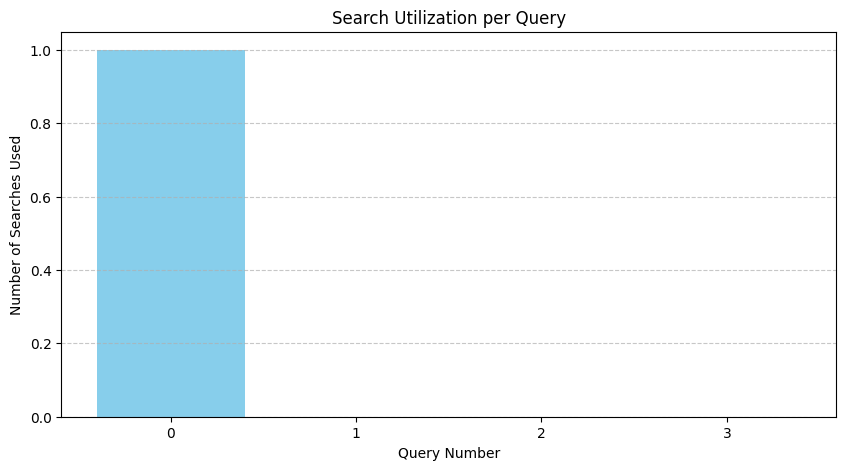


# This advanced workflow demonstrates how to break down complex research questions
# into a structured process that builds deeper insights at each stage.
# Note how the search tool is used differently at each stage of the research process.


In [ ]:
# @title ## 9a. Multi-stage Research Workflow with Progressive Refinement
# This advanced workflow demonstrates a structured research process that builds insights progressively

print("\n--- 10. Multi-stage Research Workflow ---")
print("# This workflow demonstrates how to conduct in-depth research through multiple progressive stages")

def multi_stage_research(research_topic):
    """
    Conduct a multi-stage research process with progressive refinement

    Args:
        research_topic (str): The main research topic or question

    Returns:
        List of responses from each stage
    """
    # Create a new chat with search
    research_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # Store responses for visualization
    responses = []

    # Stage 1: Initial broad exploration
    print(f"\n📊 Stage 1: Initial exploration of '{research_topic}'")
    stage1_prompt = f"""
    I'm conducting research on '{research_topic}'.
    First, provide a broad overview of this topic covering:
    1. Main concepts and terminology
    2. Current state of development
    3. Key players or contributors
    4. Recent major developments

    After providing this overview, identify 3-5 specific subtopics that would be most
    interesting for further in-depth exploration.
    """

    stage1_response = research_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Extract subtopics for deeper investigation
    print(f"\n📊 Stage 2: Identifying key subtopics for deeper investigation")
    stage2_prompt = """
    Based on your previous response, extract exactly 3 subtopics that would be most valuable
    to explore further. For each subtopic:
    1. Clearly name the subtopic
    2. Explain why it's particularly significant
    3. Identify specific aspects that need deeper research

    Present these in a clear, structured format.
    """

    stage2_response = research_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: Deep dive into first subtopic
    print(f"\n📊 Stage 3: Deep dive into first subtopic")
    stage3_prompt = """
    Let's focus on the first subtopic you identified. Please conduct a comprehensive
    deep dive into this specific area. Your analysis should include:

    1. Latest research findings or developments
    2. Key challenges or controversies
    3. Notable innovations or breakthroughs
    4. Future directions and potential impacts
    5. Leading experts, organizations, or companies

    Support your analysis with specific examples, data points, and citations
    from your search results.
    """

    stage3_response = research_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Synthesis and insights
    print(f"\n📊 Stage 4: Synthesizing insights and recommendations")
    stage4_prompt = """
    Based on all the research we've conducted so far, please:

    1. Synthesize the key findings into 3-5 major insights
    2. Identify emerging trends or patterns across the research
    3. Note any gaps or contradictions in the current knowledge
    4. Provide recommendations for practical applications of this knowledge
    5. Suggest directions for future research

    Structure this as an executive brief that could inform strategic decision-making.
    """

    stage4_response = research_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # Visualize search usage across the research stages
    print("\n📊 Research Stage Search Utilization:")
    visualize_search_usage(responses)

    return responses

# Run the multi-stage research on a complex topic
research_topic = "Quantum machine learning for drug discovery"
research_results = multi_stage_research(research_topic)

print("\n# This advanced workflow demonstrates how to break down complex research questions")
print("# into a structured process that builds deeper insights at each stage.")
print("# Note how the search tool is used differently at each stage of the research process.")


--- 11. Competitive Intelligence Framework ---
# Using Gemini's search capabilities to conduct structured competitive analysis

📊 Stage 1: Company profile and market position for Rivian


Okay, here's a comprehensive analysis of Rivian in the Electric Vehicle Manufacturing industry, based on publicly available information:



Here's an analysis of Rivian in the Electric Vehicle Manufacturing industry:

**1. Company Overview**

*   **History:** Rivian was founded in 2009 by Robert "RJ" Scaringe. The company initially operated under the name Mainstream Motors. Rivian focused on developing electric SUVs and pickup trucks.
*   **Size:** Rivian has thousands of employees. As of December 31, 2023, Rivian employed approximately 16,500 employees.
*   **Key Offerings:** Rivian's primary offerings include:
    *   R1T: An all-electric pickup truck.
    *   R1S: An all-electric SUV.
    *   Electric Delivery Van (EDV): Designed for commercial customers, particularly Amazon.
    *   Rivian Adventure Network: A network of fast-charging stations.

**2. Current Market Position and Market Share**

*   **Market Position:** Rivian is considered a key player in the electric vehicle (EV) market, particularly in the electric truck and SUV segments.
*   **Market Share:** Specific market share figures can fluctuate. In 2022, Rivian's market share in the US EV market was around 1.3%. Keep in mind that the overall EV market is dynamic, with Tesla holding the dominant share, followed by other established automakers and emerging players.

**3. Recent Financial Performance and Growth Trends**

*   **Financial Performance:**
    *   In 2023, Rivian produced 57,232 vehicles and delivered 50,122 vehicles.
    *   Rivian's revenue for the full year 2023 was $4.43 billion.
    *   The company still experiences net losses. For 2023, Rivian reported a net loss of $5.43 billion.
    *   Rivian is working towards profitability by increasing production efficiency and reducing costs.
*   **Growth Trends:** Rivian's production and deliveries have been increasing. The company is focused on scaling production and expanding its product line to drive future growth.

**4. Key Executives and Leadership Changes**

*   **Key Executives:**
    *   RJ Scaringe: Founder and CEO.
*   It's important to check recent reports for any executive leadership changes.

**5. Recent Strategic Moves**

*   **Partnerships:**
    *   Amazon: Rivian has a significant partnership with Amazon to develop and supply Electric Delivery Vans (EDVs).
*   **New Product Launches:**
    *   R2: In March 2024, Rivian revealed the R2, a smaller, more affordable SUV, slated for release in 2026.
    *   R3: Rivian also unveiled the R3, a smaller crossover, derived from the R2 platform, with further details to come.
*   **Production Expansion**:
    *   Rivian is focused on ramping up production at its Normal, Illinois factory.
*   **Cost Reduction:** The company is actively implementing cost-cutting measures to improve its financial performance.



📊 Stage 2: Competitor identification and analysis


Okay, here's a comparative analysis of Rivian's top competitors in the electric vehicle (EV) market:



Here's an analysis of Rivian's top competitors:

**1. Tesla**

*   **Company Overview:** Tesla is the leading manufacturer of electric vehicles, energy generation, and storage systems. Founded in 2003, Tesla has significantly shaped the EV market.
*   **Market Share and Position:** Tesla has the largest market share in the EV market, although its share has been decreasing. In Q4 2024, Tesla held approximately 44% of the US EV market.
*   **Key Differentiators and Competitive Advantages:**
    *   Supercharger Network: Tesla's extensive and reliable Supercharger network is a significant advantage.
    *   Technology: Tesla is known for its advanced technology, including its battery technology, autonomous driving features (Autopilot and Full Self-Driving).
    *   Brand Recognition: Tesla has strong brand recognition and customer loyalty.
*   **Recent Strategic Moves:**
    *   Expansion of Gigafactories: Tesla continues to expand its production capacity globally.
    *   New Models: Tesla is expected to release new models.
    *   Software and Services: Tesla is focusing on generating revenue through software updates and services.
*   **Strengths Relative to Rivian:**
    *   Established Infrastructure: Tesla's charging infrastructure is far more developed.
    *   Production Capacity: Tesla has significantly higher production capacity and economies of scale.
    *   Brand Recognition: Higher brand recognition and customer loyalty.
*   **Weaknesses Relative to Rivian:**
    *   Vehicle Focus: Tesla currently doesn't have a direct competitor to Rivian's R1T (electric pickup truck), though the Cybertruck is now available.
    *   Brand Image: Rivian targets a more outdoors/adventure-oriented customer base, potentially differentiating itself from Tesla's broader appeal.

**2. Ford**

*   **Company Overview:** Ford is a traditional automaker that is heavily investing in electric vehicles.
*   **Market Share and Position:** Ford is among the top EV sellers in the US. In Q4 2024, Ford's EV sales grew.
*   **Key Differentiators and Competitive Advantages:**
    *   F-150 Lightning: Ford's F-150 Lightning has been a successful electric pickup truck.
    *   Established Manufacturing: Ford has extensive manufacturing capabilities and experience.
    *   Brand Loyalty: Ford has a loyal customer base, especially in the truck market.
*   **Recent Strategic Moves:**
    *   Electrification Strategy: Ford is focusing on electric commercial vans and pickup trucks.
    *   Battery Sourcing: Ford is realigning its battery sourcing to reduce costs and improve efficiency.
*   **Strengths Relative to Rivian:**
    *   Manufacturing Expertise: Ford has a long history of mass production.
    *   Existing Infrastructure: Ford has an established dealer network and service infrastructure.
    *   Vehicle Variety: Ford provides a wider variety of vehicles beyond the truck and SUV markets that Rivian currently occupies.
*   **Weaknesses Relative to Rivian:**
    *   Brand Perception: Ford is still seen by some as a traditional automaker, which may not appeal to all EV buyers.
    *   Technology: Ford's technology may not be perceived as cutting-edge as Rivian's.

**3. General Motors (GM)**

*   **Company Overview:** GM is a traditional automaker that is rapidly expanding its electric vehicle offerings.
*   **Market Share and Position:** GM is the second-largest EV seller in the US. GM's EV sales increased significantly in 2024.
*   **Key Differentiators and Competitive Advantages:**
    *   Diverse EV Portfolio: GM is launching a range of EVs across different segments, including SUVs, trucks, and cars.
    *   Ultium Platform: GM's Ultium battery platform is a key enabler for its EV strategy.
*   **Recent Strategic Moves:**
    *   EV Sales Growth: GM's EV sales have been increasing, driven by models like the Chevrolet Equinox EV and Cadillac Lyriq.
*   **Strengths Relative to Rivian:**
    *   Manufacturing Scale: GM has massive manufacturing capabilities.
    *   Brand Portfolio: GM has a diverse portfolio of brands and vehicles.
*   **Weaknesses Relative to Rivian:**
    *   Brand Image: Similar to Ford, GM is transitioning from traditional vehicles to EVs.
    *   Market Focus: Historically concentrated on more mainstream vehicle designs, versus Rivian's adventure/off-road branding.

**4. Lucid Group**

*   **Company Overview:** Lucid Motors is a manufacturer of luxury electric vehicles.
*   **Key Differentiators and Competitive Advantages:**
    *   Luxury Focus: Caters to the high-end EV market with luxurious design and advanced technology.
*   **Recent Strategic Moves:**
    *   Focus on expanding production and deliveries of Lucid Air models.
*   **Strengths Relative to Rivian:**
    *   Luxury brand positioning that appeals to a different customer segment.
*   **Weaknesses Relative to Rivian:**
    *   Does not currently offer trucks or more rugged SUV designs, limiting appeal to Rivian’s target audience.
    *   Smaller production scale compared to Rivian.

**Important Considerations:**

*   **Market Dynamics:** The EV market is rapidly evolving, with new entrants and changing consumer preferences.
*   **Technology Advancements:** Battery technology, charging infrastructure, and autonomous driving capabilities are key areas of competition.
*   **Production Scaling:** The ability to scale production efficiently is crucial for success in the EV market.



📊 Search Results Used:



📊 Stage 3: SWOT analysis for Rivian


Okay, here's a detailed SWOT analysis for Rivian, based on the information gathered:

**Rivian SWOT Analysis**

**1. Strengths (Internal Advantages)**

*   **Innovative Product Design:** Rivian's R1T and R1S are well-regarded for their design, features, and off-road capabilities, appealing to the adventure and outdoors market.
    *   *Explanation:* Rivian has created distinctive vehicles that stand out in the EV market.
*   **Partnership with Amazon:** The partnership to develop and supply Electric Delivery Vans (EDVs) provides a stable revenue stream and a valuable proving ground for Rivian's technology.
    *   *Explanation:* The EDV contract with Amazon offers a guaranteed customer and supports production scaling.
*   **Strong Brand Image (Adventure/Sustainability):** Rivian has cultivated a brand image associated with sustainability, adventure, and a premium outdoor lifestyle, which resonates with a specific customer segment.
    *   *Explanation:* This image can command a premium price and foster customer loyalty.
*   **Technology Focus:** Rivian is focused on developing advanced technology for its vehicles, including battery technology and software features.
    *   *Explanation:* A strong technology base is essential for competing in the rapidly evolving EV market.
*   **R2 Platform:** The announcement of the R2 platform targets a broader market with a more accessible price point.
    *   *Explanation:* The R2 platform may allow Rivian to capture a larger customer base.

**2. Weaknesses (Internal Disadvantages)**

*   **Production Scaling Challenges:** Rivian has faced challenges in scaling up production to meet demand, which has impacted revenue and profitability.
    *   *Explanation:* Production bottlenecks can limit sales and increase costs.
*   **High Net Losses:** Rivian is currently operating at a significant net loss, which raises concerns about its long-term financial sustainability.
    *   *Explanation:* Continued losses may require additional funding and could impact investor confidence.
*   **Limited Service Infrastructure:** Compared to established automakers like Tesla and Ford, Rivian has a smaller service network, which could be a concern for customers.
    *   *Explanation:* Limited service locations may impact customer satisfaction and brand perception.
*   **Reliance on a Major Customer:** Rivian's reliance on Amazon for a significant portion of its revenue creates a risk if the partnership changes or Amazon reduces its orders.
    *   *Explanation:* Diversifying the customer base is important for long-term stability.
*   **New Entrant Status:** Rivian, being a relatively new company, lacks the established brand recognition and customer loyalty of legacy automakers.
    *   *Explanation:* Building brand awareness and trust takes time and investment.

**3. Opportunities (External Factors)**

*   **Growing EV Market:** The global electric vehicle market is expanding rapidly, creating opportunities for Rivian to increase its sales and market share.
    *   *Explanation:* The shift towards EVs is driven by environmental concerns, government incentives, and technological advancements.
*   **Government Incentives and Regulations:** Government policies that support EV adoption, such as tax credits and emission regulations, can benefit Rivian.
    *   *Explanation:* These policies can make EVs more affordable and attractive to consumers.
*   **Expansion of Charging Infrastructure:** The expansion of public charging infrastructure will make EV ownership more convenient and reduce range anxiety.
    *   *Explanation:* More charging stations will encourage more people to switch to EVs.
*   **Technological Advancements:** Advances in battery technology, autonomous driving, and connectivity can enhance Rivian's products and attract new customers.
    *   *Explanation:* Innovation is key to staying competitive in the EV market.
*   **Untapped Market Segments:** There are still underserved segments in the EV market, such as commercial vehicles and off-road vehicles, which Rivian can target.
    *   *Explanation:* Identifying and catering to specific needs can provide a competitive advantage.

**4. Threats (External Factors)**

*   **Intense Competition:** The electric vehicle market is becoming increasingly competitive, with established automakers and new entrants vying for market share.
    *   *Explanation:* Rivian faces competition from Tesla, Ford, GM, and other EV manufacturers.
*   **Supply Chain Disruptions:** Disruptions in the global supply chain, such as shortages of semiconductors or battery materials, can impact Rivian's production and costs.
    *   *Explanation:* Supply chain issues can delay production and increase expenses.
*   **Economic Downturn:** An economic recession or slowdown could reduce consumer spending on discretionary items like electric vehicles.
    *   *Explanation:* Economic uncertainty can negatively impact demand for EVs.
*   **Changing Government Regulations:** Changes in government regulations, such as the elimination of tax credits or stricter emission standards, could negatively impact the EV market.
    *   *Explanation:* Policy changes can affect the affordability and attractiveness of EVs.
*   **Raw Material Price Volatility:** Fluctuations in the prices of raw materials used in batteries, such as lithium and nickel, can impact Rivian's production costs.
    *   *Explanation:* High material costs can reduce profitability.



📊 Stage 4: Strategic recommendations


Here are actionable strategic recommendations for Rivian, based on the competitive intelligence gathered:

**Strategic Recommendations for Rivian Executives**

**1. Leveraging Strengths:**

*   **Recommendation:** *Amplify the Brand's "Adventure" Identity.*
    *   **Action:** Invest in marketing campaigns that showcase the R1T and R1S in real-world adventure scenarios (e.g., off-roading, camping, outdoor activities). Partner with outdoor gear companies and influencers to create authentic content and experiences.
    *   **Rationale:** Capitalizes on Rivian's strong brand image and differentiates it from competitors with a more mainstream or luxury focus.
*   **Recommendation:** *Expand Value Added Services to Enhance Customer Loyalty.*
    *   **Action:** Establish dedicated Rivian-owned service centers in key regions, while increasing the number of authorized third party service providers.
    *   **Rationale:** Rivian's limited service infrastructure could be a barrier to entry. 
*   **Recommendation:** *Continue to refine the R2 platform, while taking advantage of government EV incentives.*
    *   **Action:** Expand the targeted customer base with a more accessible price point.
    *   **Rationale:** Captures a larger customer base.

**2. Addressing Weaknesses:**

*   **Recommendation:** *Aggressively Optimize Production Efficiency and Supply Chain Management.*
    *   **Action:** Implement lean manufacturing principles, invest in automation, and diversify the supply base to reduce reliance on single suppliers. Secure long-term contracts for critical materials like battery components.
    *   **Rationale:** Addresses production scaling challenges and reduces the risk of supply chain disruptions.
*   **Recommendation:** *Implement Financial Discipline and Cost Controls.*
    *   **Action:** Conduct a comprehensive review of all operating expenses and identify areas for cost reduction. Prioritize investments with the highest potential return.
    *   **Rationale:** Mitigates high net losses and improves financial sustainability.
*   **Recommendation:** *Expand Partnerships for Charging Infrastructure Access.*
    *   **Action:** Collaborate with existing charging networks to offer Rivian customers seamless access to a wider network of charging stations. Consider developing strategic partnerships with companies that operate charging stations.
    *   **Rationale:** Addresses the limited service infrastructure and makes EV ownership more convenient for customers.

**3. Capitalizing on Market Opportunities:**

*   **Recommendation:** *Accelerate Expansion into the Commercial Vehicle Market.*
    *   **Action:** Leverage the Amazon partnership to further refine the Electric Delivery Van (EDV) and develop new commercial vehicle offerings for other customers.
    *   **Rationale:** Expands the customer base beyond individual consumers and creates a more diversified revenue stream.
*   **Recommendation:** *Monitor Government EV Incentives for the R2 platform.*
    *   **Action:** Capitalize on government policies and incentives to increase sales.
    *   **Rationale:** These policies can make EVs more affordable and attractive to consumers.

**4. Defending Against Competitive Threats:**

*   **Recommendation:** *Continuously Innovate and Differentiate Product Offerings.*
    *   **Action:** Invest in R&D to develop new features, improve performance, and stay ahead of the competition. Focus on areas where Rivian has a competitive advantage, such as off-road capabilities and adventure-focused design.
    *   **Rationale:** Deters competitive threats by creating unique and desirable products that are difficult to replicate.
*   **Recommendation:** *Aggressively Monitor and Respond to Competitor Actions.*
    *   **Action:** Conduct ongoing competitive analysis to track competitor product launches, pricing strategies, and marketing campaigns. Develop proactive strategies to counter competitor moves.
    *   **Rationale:** Helps Rivian stay informed and adapt quickly to changes in the market.

**5. Potential Areas for Innovation or Market Disruption:**

*   **Recommendation:** *Develop a Subscription-Based Service for Vehicle Features and Updates.*
    *   **Action:** Offer customers the option to subscribe to advanced features, such as enhanced autonomous driving capabilities, over-the-air software updates, and access to a curated library of adventure content.
    *   **Rationale:** Creates a recurring revenue stream and provides customers with a more flexible and personalized ownership experience.
*   **Recommendation:** *Explore Battery Technology Innovation to increase range, shorten charging times, and lower costs.*
    *   **Action:** Invest in research and development of next-generation battery technologies.
    *   **Rationale:** Battery technology is a key differentiator in the EV market.



📊 Competitive Analysis Search Utilization:


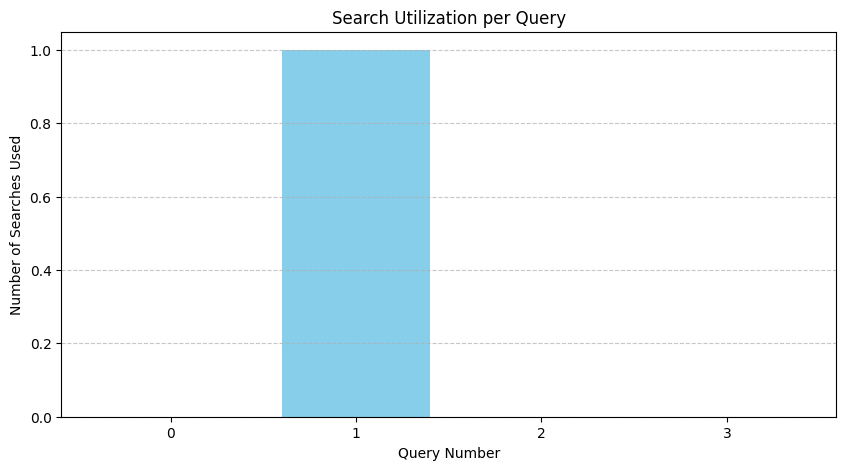


# This framework demonstrates how to use search capabilities for comprehensive competitive analysis
# The structured approach ensures thorough coverage of all aspects of competitive intelligence
# Notice how the search tool grounds the analysis in factual, up-to-date information


In [ ]:
# @title ## 9b. Competitive Intelligence Framework
#This workflow demonstrates how to use search for detailed competitive analysis

print("\n--- 11. Competitive Intelligence Framework ---")
print("# Using Gemini's search capabilities to conduct structured competitive analysis")

def competitive_intelligence_analysis(company_name, industry=None):
    """
    Conduct a structured competitive intelligence analysis for a company

    Args:
        company_name (str): The target company to analyze
        industry (str): Optional industry context

    Returns:
        List of responses from the analysis
    """
    # Create a new chat with search
    competitive_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

    # Store responses
    responses = []

    # Stage 1: Company profile and market position
    print(f"\n📊 Stage 1: Company profile and market position for {company_name}")
    stage1_prompt = f"""
    Conduct a comprehensive analysis of {company_name}{' in the ' + industry + ' industry' if industry else ''}.

    Include:
    1. Brief company overview (history, size, key offerings)
    2. Current market position and market share if available
    3. Recent financial performance and growth trends
    4. Key executives and leadership changes
    5. Recent strategic moves (acquisitions, partnerships, new product launches)

    Focus on factual information from reliable sources. Include specific numbers
    and metrics wherever possible.
    """

    stage1_response = competitive_chat.send_message(stage1_prompt)
    show_parts(stage1_response)
    responses.append(stage1_response)
    time.sleep(2)

    # Stage 2: Competitor identification and comparison
    print(f"\n📊 Stage 2: Competitor identification and analysis")
    stage2_prompt = f"""
    Identify the top 3-5 direct competitors of {company_name}.

    For each competitor:
    1. Provide a brief company overview
    2. Compare their market share and position to {company_name}
    3. Analyze their key differentiators and competitive advantages
    4. Describe their recent strategic moves
    5. Evaluate their strengths and weaknesses relative to {company_name}

    Present this in a structured comparative format.
    """

    stage2_response = competitive_chat.send_message(stage2_prompt)
    show_parts(stage2_response)
    responses.append(stage2_response)
    time.sleep(2)

    # Stage 3: SWOT analysis
    print(f"\n📊 Stage 3: SWOT analysis for {company_name}")
    stage3_prompt = f"""
    Based on the information gathered, conduct a detailed SWOT analysis for {company_name}:

    1. Strengths: Internal advantages and capabilities
    2. Weaknesses: Internal disadvantages or limitations
    3. Opportunities: External factors that could benefit the company
    4. Threats: External factors that could negatively impact the company

    For each category, provide 4-5 specific points with brief explanations supported by
    the information you've gathered.
    """

    stage3_response = competitive_chat.send_message(stage3_prompt)
    show_parts(stage3_response)
    responses.append(stage3_response)
    time.sleep(2)

    # Stage 4: Strategic recommendations
    print(f"\n📊 Stage 4: Strategic recommendations")
    stage4_prompt = f"""
    Based on all the competitive intelligence gathered, provide strategic recommendations for {company_name}.

    Your recommendations should address:
    1. How to leverage identified strengths
    2. How to address or mitigate weaknesses
    3. How to capitalize on market opportunities
    4. How to defend against competitive threats
    5. Potential areas for innovation or market disruption

    Format these as actionable strategic recommendations that could be presented to executives.
    """

    stage4_response = competitive_chat.send_message(stage4_prompt)
    show_parts(stage4_response)
    responses.append(stage4_response)

    # Visualize search usage across the analysis stages
    print("\n📊 Competitive Analysis Search Utilization:")
    visualize_search_usage(responses)

    return responses

# Run the competitive intelligence analysis on a real company
target_company = "Rivian"
industry = "Electric Vehicle Manufacturing"
competitive_results = competitive_intelligence_analysis(target_company, industry)

print("\n# This framework demonstrates how to use search capabilities for comprehensive competitive analysis")
print("# The structured approach ensures thorough coverage of all aspects of competitive intelligence")
print("# Notice how the search tool grounds the analysis in factual, up-to-date information")

In [ ]:
summary = """
## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/
"""

display(Markdown(summary))

print("Thank you for participating in this workshop!")
print("We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.")


## Workshop Summary

In this comprehensive workshop, we've explored Gemini 2.0's advanced search capabilities:

### Key Concepts Covered
- Setting up the Google Gen AI SDK environment
- Comparing responses with and without search
- Maintaining context in search-based conversations
- Creating data visualizations with search-sourced data
- Combining search with multimodal inputs
- Practical applications across various domains
- Advanced search techniques and best practices
- Integrating search with function calling

### Next Steps for Your Learning Journey

1. **Experiment with Different Models**
   - Try both Flash and Pro models to understand their strengths
   - Observe how different models utilize search resources

2. **Build a Practical Project**
   - Create a research assistant, market analyzer, or travel planner
   - Combine search with other capabilities like code generation

3. **Explore Advanced Features**
   - Dive into multimodal capabilities with image analysis
   - Experiment with combining function calling and search

4. **Contribute to the Community**
   - Share your findings and innovative applications
   - Contribute examples to open-source Gemini projects

5. **Stay Updated**
   - Gemini models and capabilities are constantly evolving
   - Check the official documentation for the latest features

### Resources
- Google Gen AI SDK Documentation: https://ai.google.dev/docs
- Gemini API Cookbook: https://github.com/google-gemini/cookbook/
- Google AI Studio: https://ai.google.dev/


Thank you for participating in this workshop!
We hope you're inspired to build amazing applications with Gemini 2.0's search capabilities.
